# Biodiversity Assesment of the Phoenix Metropolitan Area

A geographic assesment of biodiversity in the Phoenix Subdivision, utilizing the biodiversity intactness index (BII).

## Background

Between 2001 and 2019, Maricopa County, located in the Phoenix metropolitan area of Arizona, added over 270 miles of developed land. This includes buildings, roads, and other structures which have the potential to disturb and negatively impact biodiversity in surrounding areas [1]('https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/'). Measures of biodiversity, such as the biodiversity intactness index (BII), are crucial for creating conservation and restoration plans. Global raster data on BII from 2017 to 2020 was produced and published by Impact Observatory [2,]('https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf')
[3]('https://planetarycomputer.microsoft.com/dataset/io-biodiversity'). This analysis combines BII data from Impact Observity as U.S. Census shapefile data to analyze changes in BII between 2017 and 2020.


## Project Setup

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

from shapely.geometry import Polygon
from rasterio.features import rasterize

from pystac_client import Client
import planetary_computer

import os
import contextily as cx

### Loading Data
__BII will be accessed through the MPC STAC catalog, search for `io-biodiversity`:__

In [2]:
# access mpc catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,)

# store bounding box
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search for bii data for area of interest
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = '2017/2020')

# retrieve items from search
items = search.item_collection()

# store items for years of interest
item_2020 = items[0]
item_2017 = items[3]

In [3]:
# view item assets
for key in item_2017.assets.keys():
    print(key, '--', item_2017.assets[key].title)

data -- Biodiversity Intactness
tilejson -- TileJSON with default rendering
rendered_preview -- Rendered preview


In [4]:
# Read in bii rasters (squeeze and drop extra coords)
bii_2017_rast = rioxr.open_rasterio(item_2017.assets['data'].href).squeeze().drop('band')
bii_2020_rast = rioxr.open_rasterio(item_2020.assets['data'].href).squeeze().drop('band')



__Information on Phoenix subdivisions will be created using US Census data:__

In [5]:
az = gpd.read_file(os.path.join('..','data','tl_2022_04_cousub.shp'))
phx = az[az.NAME == 'Phoenix']

## Area of Interest
Before analyzing changes in biodiversity, it it is useful to visualize the area of interest. The following code produces a map of Arizona, highlighting the Phoenix Subdivision that we are interested in.

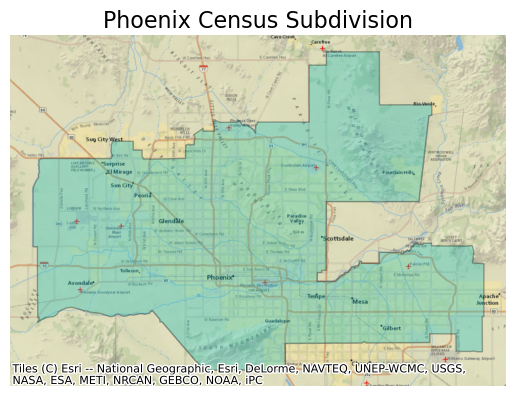

In [6]:
fig, ax = plt.subplots() #create figure

phx.to_crs(epsg=3857).plot(ax=ax, figsize = (12,8), alpha = 0.3, #plot phoenix
                          edgecolor='k', color='c')

cx.add_basemap(ax, source=cx.providers.Esri.NatGeoWorldMap) # add basemap

# update title and axes
ax.set_title("Phoenix Census Subdivision", fontdict={"fontsize": "16"})
ax.set_axis_off()
plt.savefig('../images/phoenix-census-subdivision.png')

## Assessing Biodiversity Loss
To compare biodiversity loss, the BII in 2017 and 2020 for the Phoenix metropolitain area were calculated and compared. BII raster data was filtered to calculate areas where the BII was at least 75%.

### Percentage of Area
The original raster is larger than the Phoenix subdivision, and needs to be cropped and reprojected before percentages can be calculated.

__Preparation:__

In [7]:
# Re-project so bii and phx have the same CRS
phx = phx.to_crs(bii_2017_rast.rio.crs)

# Crop raster using phx
bii_2017_rast = bii_2017_rast.rio.clip(phx['geometry'])
bii_2020_rast = bii_2020_rast.rio.clip(phx['geometry'])

__Percetange of Area in 2017:__

In [8]:
# find areas where bii is >= 0.75
high_bii_2017 = (bii_2017_rast >= 0.75)

# Convert T/F to 0/1 int
high_bii_2017 = high_bii_2017.astype(int)

# Calculate percent
bii_pcnt_2017 = (high_bii_2017.sum().item() / bii_2017_rast.count().item()) * 100

# Print percent area
print(f'Percentage of Area with BII >= 75% in 2017: {round(bii_pcnt_2017, 2)} %')

Percentage of Area with BII >= 75% in 2017: 7.13 %


__Percentage of Area in 2020:__

In [9]:
## ==== Repeat workflow for 2020 bii ====
# find areas where bii is >= 0.75
high_bii_2020 = (bii_2020_rast >= 0.75)

# Convert T/F to 0/1 int
high_bii_2020 = high_bii_2020.astype(int)

# Calculate percent
bii_pcnt_2020 = (high_bii_2020.sum().item() / bii_2020_rast.count().item()) * 100

# Print percent area
print(f'Percentage of Area with BII >= 75% in 2017: {round(bii_pcnt_2020, 2)} %')

Percentage of Area with BII >= 75% in 2017: 6.49 %


__Interpretation:__ 

Based on the percentages calculated above, the percent of area in the Phoenix Subdivision with a BII greater than or equal to 75% in 2017 was 7.13%. This is only slightly higher than the 2020 area of 6.49%, indicating minimal changes in high BII areas between 2017 and 2020.

### Mapping out BII Changes

Cropping BII data to Phoenix subdivision:

In [10]:
# create mask of Phoenix subdivision
mask = rasterize(shapes = [phx.loc[10,'geometry']],
                out_shape = bii_2020_rast.shape,
                transform = bii_2020_rast.rio.transform(),
                all_touched = True)

# apply mask over 2020 BII raster and clip
bii_phx_2020 = bii_2020_rast * mask
bii_phx_2020 = bii_phx_2020.rio.clip([phx.loc[10,'geometry']])

Find areas that fell under 0.75 BII from 2017 to 2020:

In [11]:
# Find the difference in BII between 2017 and 2020
bii_diff = high_bii_2017 - high_bii_2020

# select values of 1 (where BII dropped below 0.75 from 2017 to 2020)
bii_diff = bii_diff.where(bii_diff == 1.0)

# crop diff raster to Phoenix
bii = bii_diff * mask
bii = bii.rio.clip([phx.loc[10,'geometry']])

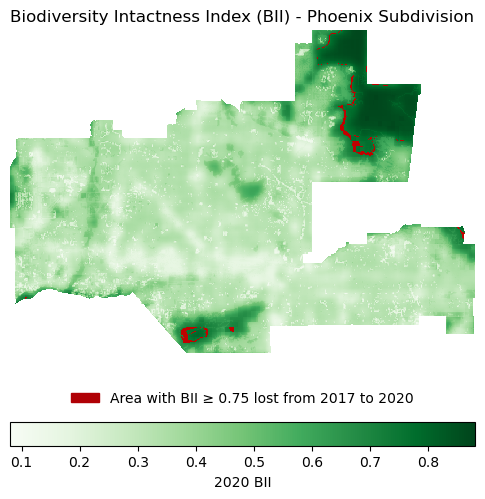

In [12]:
## === Plot highlighting areas where BII fell under 75% ===
# create empty figure
fig, ax = plt.subplots(figsize = (6,6))

# remove axis
ax.axis('off')

# plot BII from 2020
bii_phx_2020.plot(ax=ax, cmap = 'Greens',
                  cbar_kwargs={"location": "bottom",
                               'label': "2020 BII"})


# plot BII difference areas
bii.plot(ax=ax, cmap='gist_heat', add_colorbar = False)
patch = mpatches.Patch(color = '#B00005',
                      label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')
# add title
ax.set_title('Biodiversity Intactness Index (BII) - Phoenix Subdivision')

_ = ax.legend(handles = [patch], loc='lower center', frameon=False,
         bbox_to_anchor=(0.5,-0.2))
plt.savefig('../images/bii-changes.png')